In [1]:
import pandas as pd
import numpy as np
import scipy as sci
import seaborn as sns
import matplotlib.pyplot as plt
import itertools
from scipy.stats import pearsonr

In [71]:
dep = pd.read_csv("/home/annerer/Downloads/Achilles_gene_dependency.csv")

In [75]:
dep['DepMap_ID'][420:430]

420    ACH-000768
421    ACH-000769
422    ACH-000770
423    ACH-000771
424    ACH-000773
425    ACH-000774
426    ACH-000775
427    ACH-000776
428    ACH-000777
429    ACH-000778
Name: DepMap_ID, dtype: object

In [21]:
dep.shape

(769, 18119)

In [32]:
dep2 = dep

In [6]:
#dep = dep.drop('DepMap_ID',1)

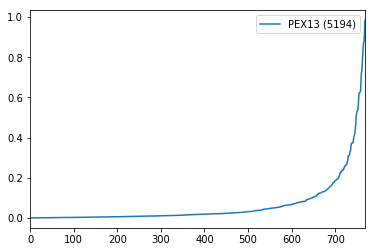

In [108]:
pex = dep["PEX13 (5194)"].sort_values()
pex = pex.reset_index()
pex = pex.drop('index',1)
pex.plot()

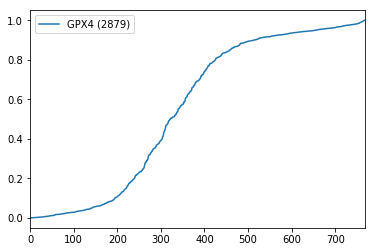

In [109]:
gpx = dep["GPX4 (2879)"].sort_values()
gpx = gpx.reset_index()
gpx = gpx.drop('index',1)
gpx.plot()

In [5]:
a = dep['A1BG (1)']
b = dep['A2M (2)']


sci.stats.pearsonr(a,b)

(0.02839725883937799, 0.4316579626191092)

In [6]:
# the matrix
correlations = dep.corr()

In [4]:
sci.stats.pearsonr(dep['A2M (2)'][1:4],dep['A2M (2)'][1:4])

(1.0, 0.0)

In [7]:
#sci.stats.pearsonr(dep.columns.values,dep.columns.values)

In [38]:
#correlations[["A2M (2)"]].sort_values(by=['A2M (2)'])

In [20]:
#pip install bioinfokit

## Test Data

In [49]:
df = pd.DataFrame(np.random.random((6, 6)), columns=['gene_' + chr(i + ord('a')) for i in range(6)]) 
print(df)

     gene_a    gene_b    gene_c    gene_d    gene_e    gene_f
0  0.197624  0.260580  0.653891  0.765120  0.368098  0.214169
1  0.592195  0.475498  0.887240  0.355919  0.041875  0.840824
2  0.368150  0.804930  0.904507  0.690116  0.631721  0.423614
3  0.530851  0.846071  0.435289  0.874329  0.395183  0.733294
4  0.537944  0.735966  0.351764  0.013963  0.618393  0.292811
5  0.939406  0.232526  0.922291  0.721885  0.545358  0.269370


In [50]:
correlations = {}
columns = df.columns.tolist()

In [51]:
for col_a, col_b in itertools.combinations(columns, 2):
    correlations[col_a + '__' + col_b] = pearsonr(df.loc[:, col_a], df.loc[:, col_b])

In [52]:
res = pd.DataFrame.from_dict(correlations, orient='index')
res.columns = ['PCC', 'p-value']

print(result.sort_index())

                                       PCC       p-value
A1BG (1)__A1CF (29974)           -0.007933  8.261635e-01
A1BG (1)__A2M (2)                 0.028397  4.316580e-01
A1BG (1)__A2ML1 (144568)          0.123012  6.292805e-04
A1BG (1)__A3GALT2 (127550)        0.162194  6.171681e-06
A1BG (1)__A4GALT (53947)          0.030070  4.050133e-01
A1BG (1)__A4GNT (51146)           0.164914  4.280512e-06
A1BG (1)__AAAS (8086)            -0.045352  2.090285e-01
A1BG (1)__AACS (65985)            0.017822  6.216910e-01
A1BG (1)__AADAC (13)              0.035006  3.323150e-01
A1BG (1)__AADACL2 (344752)        0.186395  1.927638e-07
A1BG (1)__AADACL3 (126767)       -0.020894  5.629092e-01
A1BG (1)__AADACL4 (343066)        0.092953  9.906966e-03
A1BG (1)__AADAT (51166)           0.075106  3.731330e-02
A1BG (1)__AAED1 (195827)          0.002314  9.489209e-01
A1BG (1)__AAGAB (79719)          -0.049549  1.698634e-01
A1BG (1)__AAK1 (22848)            0.006219  8.632898e-01
A1BG (1)__AAMDC (28971)        

In [56]:
sorted_pcc = result.sort_values(by=["PCC"])

In [67]:
sorted_pcc

,PCC,p-value
AARS (16)__ALOX5AP (241),-0.860687,4.619332e-227
AARS (16)__APOO (79135),-0.770419,4.251157e-152
AARS (16)__ABCA10 (10349),-0.710337,4.266430e-119
AARS (16)__ACO1 (48),-0.688335,4.796087e-109
AARS (16)__ANKRD13B (124930),-0.649842,1.820625e-93
AARS (16)__ADGRL4 (64123),-0.649495,2.456178e-93
AARS (16)__ADRA1A (148),-0.632739,3.010597e-87
ANAPC11 (51529)__ARHGAP44 (9912),-0.625192,1.259788e-84
AARS (16)__ABI3BP (25890),-0.622251,1.265207e-83
AARS (16)__ADCY5 (111),-0.620763,4.029007e-83


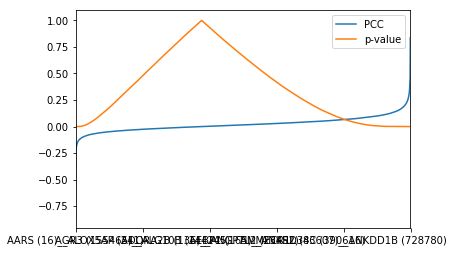

In [66]:
sorted_pcc.plot()

## Pairwise Gene Correlations DepMap 20Q2

In [47]:
data = dep2
data = data.replace(-np.inf, np.nan)
data = data.replace(np.inf,np.nan)
data = data.fillna(0)
corrs = {}
cols = data.columns.tolist()

In [73]:
#data[~data.isin([np.nan, np.inf, -np.inf]).any(1)]

In [48]:
for col_a, col_b in itertools.combinations(cols, 2):
    corrs[col_a + '__' + col_b] = pearsonr(data.loc[:, col_a], data.loc[:, col_b])

KeyboardInterrupt: 

In [ ]:
result = pd.DataFrame.from_dict(corrs, orient='index')
result.columns = ['PCC', 'p-value']

#print(result.sort_index())

result.sort_values(by=['PCC'])

In [14]:
# berechnung dauert lang, unbedingt als csv exportieren
result.to_csv('pairwise-gene-correlations-DepMap-20Q2.csv')

todo:

for the gene interaction pairs
pair-correlation-scoreverteilung binnen und plotten. Unerwartete Bimodalitaet bzw tails?


dependency-matrix clustern. ?

wir nehmen die besten 15% der scores und 
nehmen die relevanten matrixteile als unsere
neue ausgangsmatrix.

diese sollte man nun durchsuchen koennen,
naemlich nach Gen-paaren. 

dh die matrix besteht aus conditions, die
unser output sind, und signifikanten gen-paaren.

conditions bleiben alle, wir beschneiden die
gene die wir drinlassen. 

frage: wie sehen wir die? wir haben die werte
ja von den gen-paaren, und jetzt eine matrix 
von genen und conditions.



   c c c c c c c c c 

g  1 0 0 0 0 0 0 0 0 

g  1 0 0 0 0 0 0 0 0

g  

g

macht das sinn?



todo also:
how to efficiently rename colum names, for conditions.

if you can do that, i am still not sure if the same lines will mean anything.
see if it works with the depmap and the avana data.


In [ ]:
import pandas as pd
import numpy as np
import scipy as sci
import itertools
from scipy.stats import pearsonr

dep = pd.read_csv("/home/annerer/Downloads/Achilles_gene_dependency.csv")

data = dep
data = data.replace(-np.inf, np.nan)
data = data.replace(np.inf,np.nan)
data = data.fillna(0)
corrs = {}
cols = data.columns.tolist()

for col_a, col_b in itertools.combinations(cols, 2):
    corrs[col_a + '__' + col_b] = pearsonr(data.loc[:, col_a], data.loc[:, col_b])

result = pd.DataFrame.from_dict(corrs, orient='index')
result.columns = ['PCC', 'p-value']

print(result.sort_index())
# berechnung dauert lang, unbedingt als csv exportieren
result.to_csv('pairwise-gene-correlations-DepMap-20Q2.csv')